In [9]:
# Chargement/installation des modules nécessaires

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import numpy as np

try:
    import usbtmc
except:
    PYTHON_VERSION = "python3.7"
    !$PYTHON_VERSION -m pip install --upgrade pip
    !$PYTHON_VERSION -m pip uninstall -y pyvisa-py pyvisa visa PyUSB python-usbtmc
    !$PYTHON_VERSION -m pip install -U pyvisa-py pyvisa PyUSB python-usbtmc
finally:
    import usbtmc

# ipython magic command
%matplotlib inline
%load_ext autoreload
%autoreload 2


try:
    mpld3.disable_notebook()
except:
    pass


import os
import time, timeit

import misc
import acquisition

In [ ]:
# Établissement d'une instance de connexion avec l'oscilloscope
address = "USBTMC:USB0::0x05FF::0x1023::LCRY0120N12304::INSTR"[7:]

import LeCroy3022

scope = LeCroy3022.Scope(connection='usb')
scope.connect(address)

In [ ]:
# Initilialisation des réglages de l'oscilloscope pour la mesure
# sous pression à 50 kHz avec le wavemaker

# réinitialise à zéro tous les paramètres
scope.write('app.settodefaultsetup')

scope.touchscreen = False
scope.horscale = 50e-6

# ---- channel 1
scope.C1 = LeCroy3022.Channel(scope, 1)
scope.C1.coupling = 'AC1M'
scope.C1.bandwithlimit = '20MHz'
scope.write('app.Acquisition.C1.ClearSweeps ')

# ---- trigger
#    TRSL (TRIG_SLOPE) : POS, NEG
#    TRSE (TRIG_SELECT) : EDGE 
#    TRDL (TRIG_DELAY)
#    TRCP (TRIG_COUPLING)
#    TRLV (TRIG_LVL)
# Dans le cas de l'utilisation du WaveMaker à 50kHz, on se
# trig sur MONITOROUTPU du WaveMaker en voie 2.
scope.trigger = 'normal'
scope.inst.write("TRSE EDGE,SR,C2;TRSL POS;TRDL -247 us")
scope.inst.write("C2:TRLV 1V;C2:TRCP AC")

# ---- channel 2
scope.C2 = LeCroy3022.Channel(scope, 2)
scope.C2.coupling = 'AC1M'
scope.inst.write("C2:Volt_DIV 0.001;C2:TRACE OFF")

# ---- average sweeps
scope.write('app.ClearSweeps')
scope.write('app.Acquisition.Horizontal.SampleMode = "Average"')
scope.write('app.Acquisition.Horizontal.AverageSweeps = 128')
scope.write('app.Acquisition.C1.FindScale ')

In [ ]:
# Acquisitions - 

channel = 1

ech_id = 'Ech##_name_phi_d'
path_to_tests  = os.path.join(os.getcwd(),"test")
path = os.path.join(path_to_tests,ech_id)

#misc.clear_folder(path + "/")
misc.mkdir(path)

# ==================================================
# paramètre du signal de force temporel
# envoyé par la machine de traction
# ==================================================
N_cycles = 4 # nombre de cycle dans l'essai
F_max    = 1400 # Newton (point de charge maximale dans cycles)
F_min    = 100 # Newton (point de charge minimale dans cycles)
vF       = 5 # vitesse de compression (N/s)
# ==================================================

F, deltat, N_acqui = acquisition.signal_force(F_min, F_max, N_cycles, vF, M=13, plot=True, verbose=True)
print('\n Delta temporel : {} s' .format(deltat))

#time_acquisition = acquisition.run(path, scope, channel, deltat, N_acqui, countdown=10, force_fun=F)
time_acquisition = acquisition.run(path, scope, channel, deltat, N_acqui, countdown=15)

force_estimate = F(np.array(time_acquisition))
tmp_list_array = [force_estimate, np.zeros(len(force_estimate)), time_acquisition]
acquisition.save_estimated_force_to_file(tmp_list_array, path + ".txt")


In [85]:
import post, misc

path_to_files = misc.choose_a_folder(test);clear_output()
list_files = misc.list_data_files(path_to_files + '/')

signals_list = post.read_signals(list_files, Gain=20)

# si une acquisition est mauvaise, on peut la supprimer à la main avec 'pop'
#signals_list.pop(45)

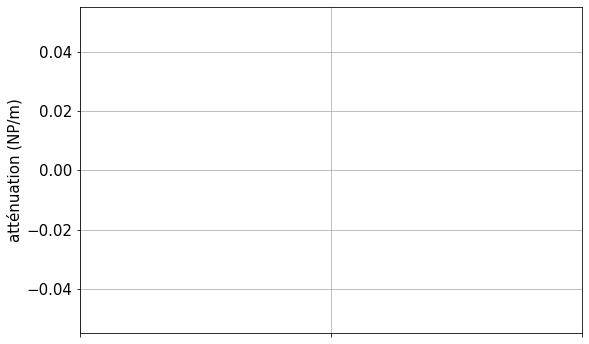

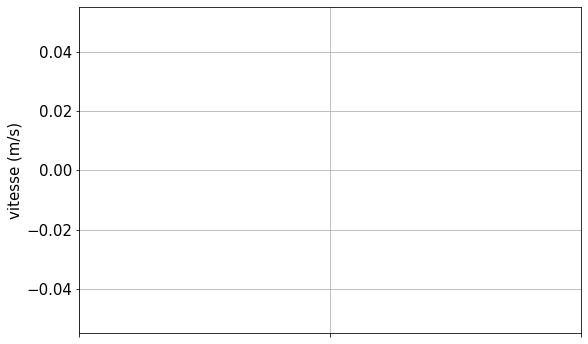

In [86]:
A, _, t = post.get_infos_signal(signals_list, reverse=False, plot=False)
dt = t-t[0]

# ==================================================
h0 = 0.03 # m
alpha0 = 0 # Np/m
c0 = 110 # m/s
n_cycle = 3
# ==================================================

time, f, dh = post.read_stress_strain(path_to_files+'.txt')
a = post.alpha(A, dh, alpha0, h0)
c = post.vitesse_tvol(dt, dh, c0, h0)
    
plt.plot(a, '.-');post.set_xtick_plot(a,n_cycle);plt.ylabel('atténuation (NP/m)');plt.show()
plt.plot(c, '.-');post.set_xtick_plot(c,n_cycle);plt.ylabel('vitesse (m/s)');plt.show()